In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!pip install librosa

In [4]:
!pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 85.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 16.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3

In [6]:
# Load the required libraries
import librosa
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.activations import linear, relu, sigmoid, softmax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import Regularizer
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
import pickle

## KNN MODEL

### Feature Extraction

In [7]:
def generate_mfcc(file_path, audio_max_length=30, max_length=1292):
    # Load audio file and sample rate
    audio, sample_rate = librosa.load(file_path, duration=audio_max_length, mono=True)
    #generate mfccs coefficients
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)

    #add padding with zeroes to standarized to fix size
    pad_width = max(0, max_length - mfccs.shape[1])

    mfccs = np.pad(mfccs, pad_width=((0,0), (0,pad_width)) , mode='constant')

    return mfccs

In [8]:
# path to root directory of file
data_directory = os.path.join('/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original')

# store the mfcc in the list
mfccs_features = []

# loop on the whole audio file through each subdirectory, where subdirectory name is the genre name(label)
for subdir, dirs, files in os.walk(data_directory):
    for file in files:
        try:
            file_path = os.path.join(subdir, file)
            mfccs = generate_mfcc(file_path)
            if mfccs is not None:
                # append the features and genre type to make dataset
#                 scaler = StandardScaler()
#                 mfccs = scaler.fit_transform(mfccs.T).T
                mfccs_features.append([mfccs, os.path.basename(subdir)])
        except Exception as e:
            print(f"The file is corrupt {file_path} {e}")

print("MFCCs Feature Generation Completed")

/tmp/ipykernel_34/3440194845.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(file_path, duration=audio_max_length, mono=True)
/opt/conda/lib/python3.10/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


The file is corrupt /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav 
MFCCs Feature Generation Completed


In [9]:
'''
mfccs_features consists of 999 rows, and in each row there are (13, 1292) where for 13 columns (n_mfcc=13, i.e mfcc coefficients), 
and 1 label column, we need to populate 1292 rows(1292 is the number of frames in which audio file is divided),
the loop takes the features loop through it and assign coef values and labels and create df
'''
for i, mfccs in enumerate(mfccs_features):
    mfccs_coef = np.transpose(mfccs[0])
    mfccs_label = mfccs[1]
    if i == 0:
        columns = [f"MFCCs_features_{j+1}" for j in range(len(mfccs[0]))]
        mfcc_df = pd.DataFrame(mfccs_coef, columns=columns)
        mfcc_df['label'] = mfccs_label
#         print(mfcc_df)
    else:
        # Create the DataFrame
        new_row = pd.DataFrame(mfccs_coef, columns=columns)
        new_row['label'] = mfccs_label
        mfcc_df = pd.concat([mfcc_df, new_row], ignore_index=True)

In [10]:
mfcc_df.tail()

,MFCCs_features_1,MFCCs_features_2,MFCCs_features_3,MFCCs_features_4,MFCCs_features_5,MFCCs_features_6,MFCCs_features_7,MFCCs_features_8,MFCCs_features_9,MFCCs_features_10,MFCCs_features_11,MFCCs_features_12,MFCCs_features_13,label
1290703,-67.003922,50.652145,1.668616,19.580383,5.633973,-7.534546,16.704620,14.653037,0.766051,-2.463384,14.712740,9.625757,-7.203941,pop
1290704,-68.250984,50.941017,-2.698970,16.414864,5.536290,-7.650269,11.990719,15.229430,0.020007,-4.680606,9.275765,8.806202,-6.053632,pop
1290705,-68.265160,51.609108,-0.251103,16.899624,3.647556,-8.171855,11.922400,18.996235,0.432642,-2.490727,4.038149,13.032079,-4.542232,pop
1290706,-63.570831,57.245285,-1.596877,19.301294,9.417267,-11.014251,8.484644,14.378709,-2.912868,1.712674,-0.374954,8.199575,-3.200050,pop
1290707,-69.938156,64.277138,3.832459,21.017876,12.993607,-6.572492,6.786780,3.209523,-2.940912,1.997834,1.424371,6.293500,3.412499,pop


In [11]:
mfcc_df.shape

(1290708, 14)

In [12]:
mfcc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1290708 entries, 0 to 1290707
Data columns (total 14 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   MFCCs_features_1   1290708 non-null  float32
 1   MFCCs_features_2   1290708 non-null  float32
 2   MFCCs_features_3   1290708 non-null  float32
 3   MFCCs_features_4   1290708 non-null  float32
 4   MFCCs_features_5   1290708 non-null  float32
 5   MFCCs_features_6   1290708 non-null  float32
 6   MFCCs_features_7   1290708 non-null  float32
 7   MFCCs_features_8   1290708 non-null  float32
 8   MFCCs_features_9   1290708 non-null  float32
 9   MFCCs_features_10  1290708 non-null  float32
 10  MFCCs_features_11  1290708 non-null  float32
 11  MFCCs_features_12  1290708 non-null  float32
 12  MFCCs_features_13  1290708 non-null  float32
 13  label              1290708 non-null  object 
dtypes: float32(13), object(1)
memory usage: 73.9+ MB


### Data Visualization

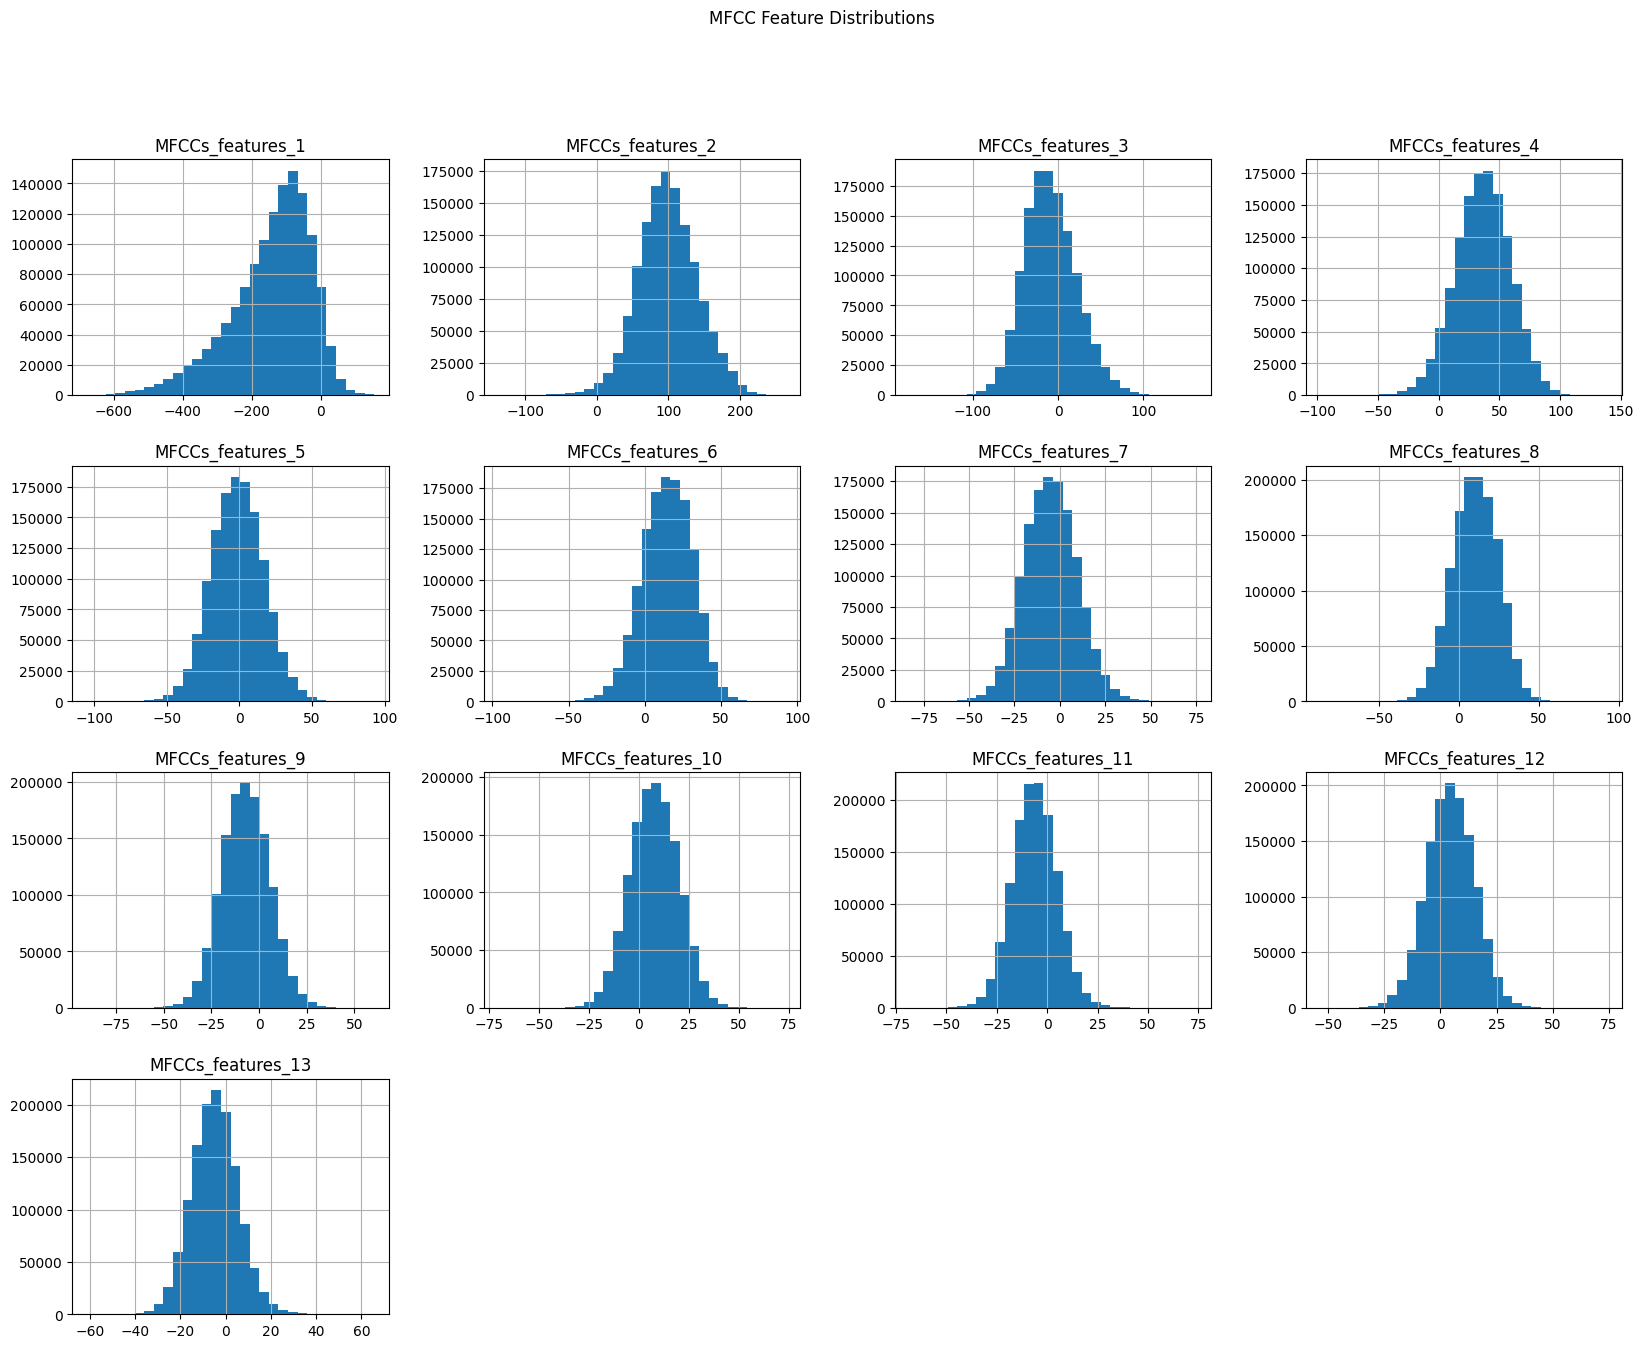

In [13]:
mfcc_df.drop('label', axis=1).hist(bins=30, figsize=(20, 15))
plt.suptitle('MFCC Feature Distributions')
plt.show()

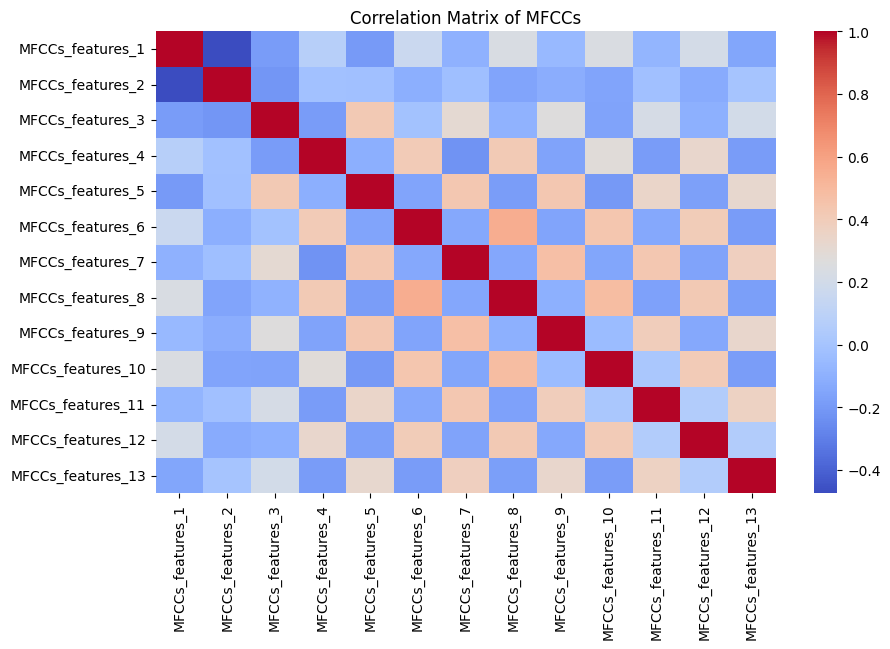

In [14]:
corr = mfcc_df.drop('label', axis=1).corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title('Correlation Matrix of MFCCs')
plt.show()


### Data Preprocessing

**Normalization/Standardization**

In [15]:
# seperate features and categorical column 'label'
X = mfcc_df.drop('label', axis=1)
y = mfcc_df['label']

# standardize the features value
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# label encoding of target value to train ML model
labelEncoder = LabelEncoder()
y_encoded = labelEncoder.fit_transform(y)

### Model Train and Test

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

In [17]:
print("X train shape: ", X_train.shape)
print("X test shape: ", X_test.shape)
print("Y train shape: ", y_train.shape)
print("X test shape: ", y_test.shape)

X train shape:  (1032566, 13)
X test shape:  (258142, 13)
Y train shape:  (1032566,)
X test shape:  (258142,)


**KNN CLASSIFIER**

In [18]:
import math

k = math.ceil(math.sqrt(len(X_train)))
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1017)

In [ ]:
y_pred = knn.predict(X_test)

In [ ]:
print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report: {classification_report(y_test, y_pred)}")
print(f"Confusion Matrix: {confusion_matrix(y_test, y_pred)}")

## CNN MODEL
- Usin Melspectogram of audio files

**Converting audio files to Mel Spectrogram**

In [3]:
def generate_melspectrogram(file_path, audio_max_length=30, max_length=1292):
    # Load audio file and sample rate
    audio, sample_rate = librosa.load(file_path, duration=audio_max_length, mono=True)
    # generate mel spectrogram
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
    # Log improves visualization and model performance
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    # add padding with zeroes to fix the size error that occurs while converting this value to required format for CNN
    pad_width = max(0, max_length - log_spectrogram.shape[1])
    padded_log_spectrogram = np.pad(log_spectrogram, pad_width=((0,0), (0,pad_width)) , mode='constant')    
    return padded_log_spectrogram

In [4]:
# path to root directory of file
data_directory = os.path.join('/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original')

# store the spectrogram in the list
mel_spectrograms = []

# loop on the whole audio file through each subdirectory, where subdirectory name is the genre name(label)
for subdir, dirs, files in os.walk(data_directory):
    for file in files:
        try:
            file_path = os.path.join(subdir, file)
            spectrogram = generate_melspectrogram(file_path)
            if spectrogram is not None:
                # append the features and genre type to make dataset
                mel_spectrograms.append([spectrogram, os.path.basename(subdir)])
        except Exception as e:
            print(f"The file is corrupt {file_path} {e}")

print("Mel Spectrograms Generation Completed")

/tmp/ipykernel_33/3615193179.py:3: UserWarning: PySoundFile failed. Trying audioread instead.

  audio, sample_rate = librosa.load(file_path, duration=audio_max_length, mono=True)

/opt/conda/lib/python3.10/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load

	Deprecated as of librosa version 0.10.0.

	It will be removed in librosa version 1.0.

  y, sr_native = __audioread_load(path, offset, duration, dtype)


The file is corrupt /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav 

Mel Spectrograms Generation Completed


In [5]:
len(mel_spectrograms)

999

In [6]:
mel_spectrograms_new = mel_spectrograms

In [7]:
spectrograms = [spectrogram[0] for spectrogram in mel_spectrograms]
label = [label[1] for label in mel_spectrograms]

In [8]:
len(label)

999

In [9]:
spectrograms[0].shape
label[0]

'disco'

**Label Encoding the Target value (genre)**

In [10]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(label)

In [11]:
X = np.array(spectrograms)
y = np.array(y)

In [12]:
X.shape

(999, 128, 1292)

In [13]:
y.shape

(999,)

In [109]:
# X = np.array([np.expand_dims(s, axis=-1) for s in spectrograms])
# X[0]

In [14]:
X.shape

(999, 128, 1292)

In [15]:
y.shape

(999,)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [17]:
X_train = X_train[..., np.newaxis]
y_train = y_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
y_val = y_val[..., np.newaxis]

In [18]:
X_train[0]

array([[[-33.728294],
        [-40.04199 ],
        [-46.296047],
        ...,
        [-55.225346],
        [-41.22974 ],
        [-25.120838]],

       [[-31.054962],
        [-35.715393],
        [-40.604332],
        ...,
        [-40.624844],
        [-30.491241],
        [-15.846237]],

       [[-28.467829],
        [-29.643694],
        [-32.44992 ],
        ...,
        [-39.572372],
        [-25.459496],
        [-12.858051]],

       ...,

       [[-77.083206],
        [-80.      ],
        [-80.      ],
        ...,
        [-80.      ],
        [-80.      ],
        [-73.981   ]],

       [[-77.886055],
        [-80.      ],
        [-80.      ],
        ...,
        [-80.      ],
        [-80.      ],
        [-74.009155]],

       [[-78.33706 ],
        [-80.      ],
        [-80.      ],
        ...,
        [-80.      ],
        [-80.      ],
        [-74.05217 ]]], dtype=float32)

In [20]:
X_train.shape

(799, 128, 1292, 1)

In [21]:
input_size = X_train.shape[1:]

In [25]:
# Sequential model
tf.random.set_seed(1234) #added for consistent results

model = Sequential([
    # Convolutional Layer 1
    Conv2D(32, (3,3), activation='relu', input_shape=input_size, kernel_regularizer = tf.keras.regularizers.l2(0.1)),
    MaxPooling2D((3, 3), strides=(2,2), padding='same'),
    BatchNormalization(),
    # Convolutional Layer 2
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.1)),
    MaxPooling2D((3, 3), strides=(2,2), padding='same'),
    BatchNormalization(),
    # Convolutional Layer 3
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.1)),
    MaxPooling2D((3, 3), strides=(2,2), padding='same'),
    BatchNormalization(),
    # prevents overfitting
    Dropout(0.3),
    # Flatten the output of convolutional layer before passing to dense layer
    Flatten(), 
    Dense(64, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.1)),
    # Here 10 in the outer layer because 10 is the numbers of genre(target), we have
    Dense(10, activation='softmax')
    
])




In [26]:
model.summary()

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv2d (Conv2D)             (None, 126, 1290, 32)     320       

                                                                 

 max_pooling2d (MaxPooling2  (None, 63, 645, 32)       0         

 D)                                                              

                                                                 

 batch_normalization (Batch  (None, 63, 645, 32)       128       

 Normalization)                                                  

                                                                 

 conv2d_1 (Conv2D)           (None, 61, 643, 32)       9248      

                                                                 

 max_pooling2d_1 (MaxPoolin  (None, 31, 322, 32)       0         

 g2D)                                                            

                                        

In [29]:
# add early stopping, to stop overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=10, mode='max', restore_best_weights=True)


In [30]:
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [31]:
# history = model.fit(train_data, epochs=40, validation_data=validation_data, callbacks=[early_stopping])
history = model.fit(X_train,y_train, epochs=40, validation_data=(X_val, y_val))

Epoch 1/40

25/25 [==============================] - 117s 5s/step - loss: 26.6155 - accuracy: 0.1402 - val_loss: 89.8562 - val_accuracy: 0.1000

Epoch 2/40

25/25 [==============================] - 110s 4s/step - loss: 17.5454 - accuracy: 0.1364 - val_loss: 24.3532 - val_accuracy: 0.1550

Epoch 3/40

25/25 [==============================] - 109s 4s/step - loss: 11.2370 - accuracy: 0.2028 - val_loss: 11.0365 - val_accuracy: 0.1000

Epoch 4/40

25/25 [==============================] - 106s 4s/step - loss: 8.7725 - accuracy: 0.2816 - val_loss: 8.7421 - val_accuracy: 0.2000

Epoch 5/40

25/25 [==============================] - 100s 4s/step - loss: 8.1854 - accuracy: 0.3667 - val_loss: 9.7127 - val_accuracy: 0.2050

Epoch 6/40

25/25 [==============================] - 101s 4s/step - loss: 8.5496 - accuracy: 0.5169 - val_loss: 9.1376 - val_accuracy: 0.2250

Epoch 7/40

25/25 [==============================] - 106s 4s/step - loss: 7.4346 - accuracy: 0.5357 - val_loss: 8.6778 - val_accuracy: 0

**CNN with Hyperparamter Tuning**

In [17]:
def cnn_model(conv1_filters=16, conv2_filters=32, conv3_filters=64, dense_units=128, dropout_rate=0.5):
    model = Sequential([
        Conv2D(conv1_filters, (3, 3), activation='relu', input_shape=input_size),
        MaxPooling2D((2, 2)),
        Conv2D(conv2_filters, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(conv3_filters, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(10, activation='softmax')  # Assuming 10 classes
    ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [18]:
model = KerasClassifier(build_fn=cnn_model, epochs=20, batch_size=32, verbose=0, conv1_filters=16, conv2_filters=32, conv3_filters=64, dense_units=128, dropout_rate=0.5)

In [19]:
param_dict = {
    'conv1_filters': [16, 32, 64],
    'conv2_filters': [32, 64, 128],
    'conv3_filters': [64, 128, 256],
    'dense_units': [64, 128, 256],
    'dropout_rate': [0.3, 0.4, 0.5]
}


In [ ]:
model.get_params().keys()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dict, n_iter=10, cv=3, verbose=2, n_jobs=-1)
random_search_cnn = random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/opt/conda/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.

  X, y = self._initialize(X, y)


[CV] END conv1_filters=16, conv2_filters=64, conv3_filters=256, dense_units=256, dropout_rate=0.3; total time=35.8min


/opt/conda/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.

  X, y = self._initialize(X, y)


[CV] END conv1_filters=16, conv2_filters=64, conv3_filters=256, dense_units=256, dropout_rate=0.3; total time=36.7min


/opt/conda/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.

  X, y = self._initialize(X, y)


[CV] END conv1_filters=16, conv2_filters=64, conv3_filters=256, dense_units=256, dropout_rate=0.3; total time=37.3min


/opt/conda/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.

  X, y = self._initialize(X, y)


[CV] END conv1_filters=64, conv2_filters=64, conv3_filters=128, dense_units=128, dropout_rate=0.3; total time=47.8min


/opt/conda/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.

  X, y = self._initialize(X, y)


[CV] END conv1_filters=64, conv2_filters=64, conv3_filters=128, dense_units=128, dropout_rate=0.3; total time=45.7min


/opt/conda/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.

  X, y = self._initialize(X, y)


[CV] END conv1_filters=64, conv2_filters=128, conv3_filters=256, dense_units=128, dropout_rate=0.4; total time=80.0min


/opt/conda/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.

  X, y = self._initialize(X, y)


In [ ]:
print("Best: %f using %s" % (random_search_cnn.best_score_, random_search_cnn.best_params_))


### Generate images of audio


In [ ]:
y, sr = librosa.load(blue_genre, duration=30)
s = librosa.feature.melspectrogram(y=y, sr=sr)
s
log_S = librosa.power_to_db(s, ref=np.max)
log_S

In [ ]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 4))
# librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
# plt.title('Mel Power Spectrogram')
# plt.colorbar(format='%+02.0f dB')
# plt.tight_layout()
# plt.show()

## Updated Model training (CNN)
- Using MFCCs of audio files
- Perform Data Augumentation

In [6]:
# location of audio files
data_directory = os.path.join('/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original')
# path where processed audio file will be stored
output_path = '/kaggle/working/mfcc.json'

AUDIO_MAX_LENGTH = 30
AUDIO_SLICE_DURATION = 3
# audio slices 
TOTAL_SLICES = AUDIO_MAX_LENGTH // AUDIO_SLICE_DURATION

# sampling rate
sr = 22050
# To make sure, all files have sample amount of samples, choose the duration less than audio file
TOTAL_SAMPLES = 29 * sr
SAMPLES_PER_SLICE = int(TOTAL_SAMPLES / TOTAL_SLICES)

# dictionary to store genre & respective enoded values
genre_dict  = dict()

In [7]:
import json

def process_audio(data_directory, output_path):
    # dictionary to store data and label
    data_dict = {
        "mfccs" : [],
        "labels" : []
    }
    # loop on the whole audio file through each subdirectory, where subdirectory name is the genre name(label)
    for subdir, dirs, files in os.walk(data_directory):
        for file in files:
            try:
                file_path = os.path.join(subdir, file)
                # Load audio file and sample rate
                audio, sample_rate = librosa.load(file_path, duration=AUDIO_MAX_LENGTH)
                #generate mfccs coefficients
                for s in range(TOTAL_SLICES):
                    start_sample = SAMPLES_PER_SLICE * s
                    end_sample = start_sample + SAMPLES_PER_SLICE
                    mfcc = librosa.feature.mfcc(y=audio[start_sample:end_sample], sr=sr, n_mfcc=13)
                    if mfcc is not None:
                        mfcc = mfcc.T
                        # append the features and genre type to make dataset
                        data_dict["labels"].append(os.path.basename(subdir)) 
                        data_dict["mfccs"].append(mfcc.tolist())

            except Exception as e:
                print(f"The file is corrupt {file_path} {e}")

    print("Mel Spectrograms Generation Completed")
    # write in json file to reuse
    with open(output_path, 'w') as f:
        json.dump(data_dict, f)
    f.close()
    

In [8]:
def label_encoding(labels):
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    # assign the label and encoded label in dict, to check the genre later while predicting the data
    global genre_dict
    genre_dict = {encoded_label: label for encoded_label, label in zip(encoded_labels, labels )}
    print(genre_dict)
    return encoded_labels
    

In [9]:
def load_processed_audio_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    f.close()

    # Load the data as numpy array for model compatibility
    X = np.array(data["mfccs"])
    y = label_encoding(data["labels"])
    y = np.array(y)

    return X, y
    

In [10]:
def prepare_data_for_model(X, y, split_size):
    # divide data in train, val & test
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=split_size)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=split_size)
    
    # convert data to 3D for CNN
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    
    return X_train, X_val, X_test,  y_train, y_val, y_test

In [11]:
def cnn_model(input_shape, conv1_filters=32, conv1_kernel_size=(3,3), conv2_filters=32, 
              conv2_kernel_size=(3,3), conv3_filters=32, conv3_kernel_size=(2,2), dense_units=64,
              dropout_rate=0.3):
    model = Sequential([
        Conv2D(conv1_filters, conv1_kernel_size, activation='relu', input_shape=input_shape),
        MaxPooling2D((3,3), strides=(2,2), padding='same'),
        BatchNormalization(),
        
        Conv2D(conv2_filters, conv2_kernel_size, activation='relu'),
        MaxPooling2D((3,3), strides=(2,2), padding='same'),
        BatchNormalization(),
        
        Conv2D(conv3_filters, conv3_kernel_size, activation='relu'),
        MaxPooling2D((3,3), strides=(2,2), padding='same'),
        BatchNormalization(),
        Dropout(dropout_rate),
        
        Flatten(),
        Dense(dense_units, activation='relu'), 
        Dense(10, activation='softmax')
    ])
    
    model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.001),
                     loss='sparse_categorical_crossentropy',
                     metrics = ['acc']
                     )
    
    return model

In [12]:
# function to make prediction on test data
def genre_predictions(model, X_test, y_test, index):
    prediction = model.predict(X_test)
    predicted_genre = np.argmax(prediction[index])
    print(f"Original Genre: {genre_dict[y_test[index]]}, Predicted Genre: {genre_dict[predicted_genre]}")

In [13]:
# plot the train and validation accuracy & loss using seaborn lineplot
def plot_result(history):
#     print(history.history.keys())
    history = history.history
    
    epochs = range(len(history['acc']))
    sns.lineplot(x=epochs, y=history['acc'], data=history, label="Training Accuracy")
    sns.lineplot(x=epochs, y=history['val_acc'], data=history, label="Validation Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.show()
    
    sns.lineplot(x=epochs, y=history['loss'], data=history, label="Training Loss")
    sns.lineplot(x=epochs, y=history['val_loss'], data=history, label="Validation Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.show()

In [14]:
# call process_audio, load_processed_audio_data & prepare_data_for_model functions
if os.path.isfile(output_path) == False:
    process_audio(data_directory, output_path)
X, y = load_processed_audio_data(file_path=output_path)
# spliting data in 80:20 ratio for train & validation and further 80:20 for train & test
X_train, X_val, X_test,  y_train, y_val, y_test = prepare_data_for_model(X, y, 0.2)

input_shape = X_train.shape[1:]
print((X_train.shape[1], X_train.shape[2], 1))
print(input_shape)
print(X_train.shape)

/tmp/ipykernel_33/438082704.py:15: UserWarning: PySoundFile failed. Trying audioread instead.

  audio, sample_rate = librosa.load(file_path, duration=AUDIO_MAX_LENGTH)

/opt/conda/lib/python3.10/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load

	Deprecated as of librosa version 0.10.0.

	It will be removed in librosa version 1.0.

  y, sr_native = __audioread_load(path, offset, duration, dtype)


The file is corrupt /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav 

Mel Spectrograms Generation Completed

{3: 'disco', 6: 'metal', 8: 'reggae', 0: 'blues', 9: 'rock', 1: 'classical', 5: 'jazz', 4: 'hiphop', 2: 'country', 7: 'pop'}

(125, 13, 1)

(125, 13, 1)

(6393, 125, 13, 1)


In [14]:
# initialize the model without hyper parameter tuning
model = cnn_model(input_shape)
model.summary()
    
# fit the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=30,
                    batch_size=32
                    )

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv2d (Conv2D)             (None, 123, 11, 32)       320       

                                                                 

 max_pooling2d (MaxPooling2  (None, 62, 6, 32)         0         

 D)                                                              

                                                                 

 batch_normalization (Batch  (None, 62, 6, 32)         128       

 Normalization)                                                  

                                                                 

 conv2d_1 (Conv2D)           (None, 60, 4, 32)         9248      

                                                                 

 max_pooling2d_1 (MaxPoolin  (None, 30, 2, 32)         0         

 g2D)                                                            

                                        

In [15]:
loss, accuracy = model.evaluate(X_test, y_test)

print(f'Loss: {loss}, Accuracy: {accuracy}')

50/50 [==============================] - 0s 7ms/step - loss: 0.7829 - acc: 0.7892

Loss: 0.7829149961471558, Accuracy: 0.7892432808876038


In [16]:
# Testing the model on never seen before data.
genre_predictions(model, X_test, y_test, 24)
genre_predictions(model, X_test, y_test, 14)
genre_predictions(model, X_test, y_test, 144)
genre_predictions(model, X_test, y_test, 121)
genre_predictions(model, X_test, y_test, 39)
genre_predictions(model, X_test, y_test, 170)
genre_predictions(model, X_test, y_test, 25)

50/50 [==============================] - 1s 9ms/step

Original Genre: classical, Predicted Genre: classical

50/50 [==============================] - 0s 7ms/step

Original Genre: jazz, Predicted Genre: jazz

50/50 [==============================] - 0s 7ms/step

Original Genre: blues, Predicted Genre: blues

50/50 [==============================] - 0s 9ms/step

Original Genre: disco, Predicted Genre: disco

50/50 [==============================] - 0s 9ms/step

Original Genre: reggae, Predicted Genre: reggae

50/50 [==============================] - 0s 7ms/step

Original Genre: metal, Predicted Genre: metal

50/50 [==============================] - 0s 7ms/step

Original Genre: rock, Predicted Genre: country


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

  with pd.option_context('mode.use_inf_as_na', True):

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

  with pd.option_context('mode.use_inf_as_na', True):

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

  with pd.option_context('mode.use_inf_as_na', True):

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating inste

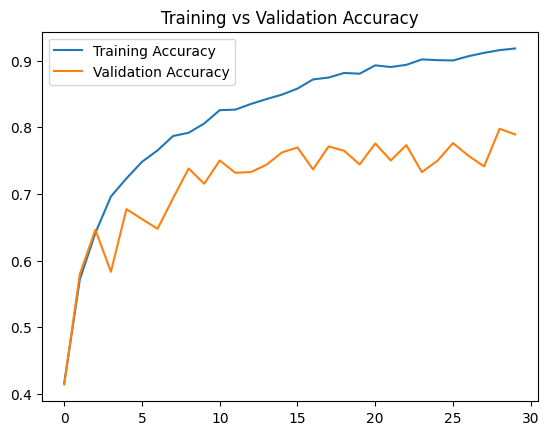

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

  with pd.option_context('mode.use_inf_as_na', True):

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

  with pd.option_context('mode.use_inf_as_na', True):

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

  with pd.option_context('mode.use_inf_as_na', True):

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating inste

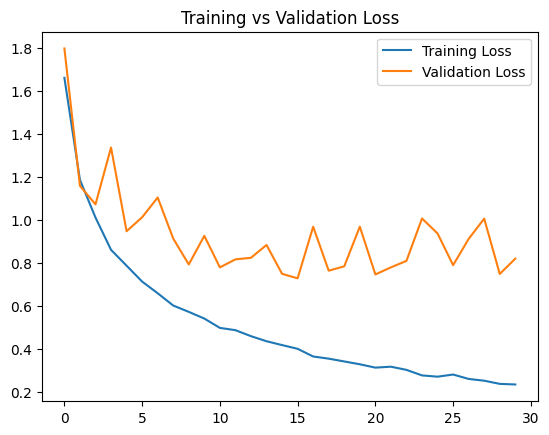

In [17]:
# call plot function to plot the tuned model
plot_result(history)

In [18]:
model.save('cnn_model.h5')

from keras.models import load_model

loaded_model = load_model("cnn_model.h5")

genre_predictions(loaded_model, X_test, y_test, 24)

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

  saving_api.save_model(


50/50 [==============================] - 0s 7ms/step

Original Genre: classical, Predicted Genre: classical


### Hyperparameter Tuning
- RandomizedSearchCV

In [19]:
# define hyper-parameters to tune & perform hyperparameter tuning
param_grid = {
    'conv1_filters': [32, 64],
    'conv2_filters': [32, 64],
    'conv3_filters': [32, 64],
    'dropout_rate': [0.3, 0.5]
}
    
# Using Randomized search CV to find best params
    
model = KerasClassifier(model=cnn_model, epochs=10, batch_size=32, verbose=0,
            input_shape=input_shape, conv1_filters=32, conv1_kernel_size=(3,3), conv2_filters=32, conv2_kernel_size=(3,3), 
            conv3_filters=32, conv3_kernel_size=(2,2), dense_units=64, dropout_rate=0.3
            )

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,n_iter=10, cv=3, verbose=2, random_state=42)
    
result = random_search.fit(X_train, y_train)
    
print("Best: %f using %s" % (random_search.best_score_, random_search.best_params_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits

[CV] END conv1_filters=32, conv2_filters=32, conv3_filters=32, dropout_rate=0.3; total time=  35.7s

[CV] END conv1_filters=32, conv2_filters=32, conv3_filters=32, dropout_rate=0.3; total time=  35.6s

[CV] END conv1_filters=32, conv2_filters=32, conv3_filters=32, dropout_rate=0.3; total time=  35.2s

[CV] END conv1_filters=32, conv2_filters=32, conv3_filters=32, dropout_rate=0.5; total time=  35.7s

[CV] END conv1_filters=32, conv2_filters=32, conv3_filters=32, dropout_rate=0.5; total time=  35.1s

[CV] END conv1_filters=32, conv2_filters=32, conv3_filters=32, dropout_rate=0.5; total time=  35.1s

[CV] END conv1_filters=32, conv2_filters=64, conv3_filters=32, dropout_rate=0.5; total time=  41.3s

[CV] END conv1_filters=32, conv2_filters=64, conv3_filters=32, dropout_rate=0.5; total time=  41.3s

[CV] END conv1_filters=32, conv2_filters=64, conv3_filters=32, dropout_rate=0.5; total time=  41.4s

[CV] END conv1_filters=64, co

In [20]:
# using best_params generated by randomized search CV to fit model
best_params = random_search.best_params_
tuned_cnn_model = cnn_model(input_shape=input_shape, **best_params)
history = tuned_cnn_model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=32
                    )

Epoch 1/50

200/200 [==============================] - 11s 50ms/step - loss: 1.7222 - acc: 0.4253 - val_loss: 1.7290 - val_acc: 0.4394

Epoch 2/50

200/200 [==============================] - 9s 47ms/step - loss: 1.2458 - acc: 0.5597 - val_loss: 1.0936 - val_acc: 0.6186

Epoch 3/50

200/200 [==============================] - 9s 46ms/step - loss: 1.0243 - acc: 0.6423 - val_loss: 0.9857 - val_acc: 0.6602

Epoch 4/50

200/200 [==============================] - 9s 46ms/step - loss: 0.9003 - acc: 0.6837 - val_loss: 1.2564 - val_acc: 0.6086

Epoch 5/50

200/200 [==============================] - 9s 47ms/step - loss: 0.8023 - acc: 0.7230 - val_loss: 0.7996 - val_acc: 0.7262

Epoch 6/50

200/200 [==============================] - 9s 45ms/step - loss: 0.7450 - acc: 0.7417 - val_loss: 0.9874 - val_acc: 0.6952

Epoch 7/50

200/200 [==============================] - 9s 46ms/step - loss: 0.6897 - acc: 0.7568 - val_loss: 0.8129 - val_acc: 0.7297

Epoch 8/50

200/200 [==============================] -

In [21]:
loss, accuracy = tuned_cnn_model.evaluate(X_test, y_test)

print(f'Loss: {loss}, Accuracy: {accuracy}')

50/50 [==============================] - 1s 10ms/step - loss: 0.7313 - acc: 0.8093

Loss: 0.7312852144241333, Accuracy: 0.8092557787895203


In [22]:
genre_predictions(tuned_cnn_model, X_test, y_test, 24)
genre_predictions(tuned_cnn_model, X_test, y_test, 14)
genre_predictions(tuned_cnn_model, X_test, y_test, 144)
genre_predictions(tuned_cnn_model, X_test, y_test, 121)
genre_predictions(tuned_cnn_model, X_test, y_test, 39)
genre_predictions(tuned_cnn_model, X_test, y_test, 170)
genre_predictions(tuned_cnn_model, X_test, y_test, 25)

50/50 [==============================] - 1s 10ms/step

Original Genre: classical, Predicted Genre: classical

50/50 [==============================] - 1s 10ms/step

Original Genre: jazz, Predicted Genre: jazz

50/50 [==============================] - 1s 10ms/step

Original Genre: blues, Predicted Genre: blues

50/50 [==============================] - 1s 11ms/step

Original Genre: disco, Predicted Genre: disco

50/50 [==============================] - 1s 12ms/step

Original Genre: reggae, Predicted Genre: reggae

50/50 [==============================] - 1s 11ms/step

Original Genre: metal, Predicted Genre: metal

50/50 [==============================] - 1s 11ms/step

Original Genre: rock, Predicted Genre: rock


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

  with pd.option_context('mode.use_inf_as_na', True):

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

  with pd.option_context('mode.use_inf_as_na', True):

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

  with pd.option_context('mode.use_inf_as_na', True):

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating inste

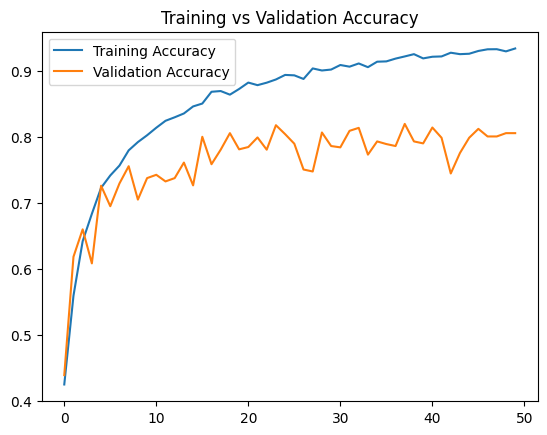

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

  with pd.option_context('mode.use_inf_as_na', True):

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

  with pd.option_context('mode.use_inf_as_na', True):

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

  with pd.option_context('mode.use_inf_as_na', True):

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating inste

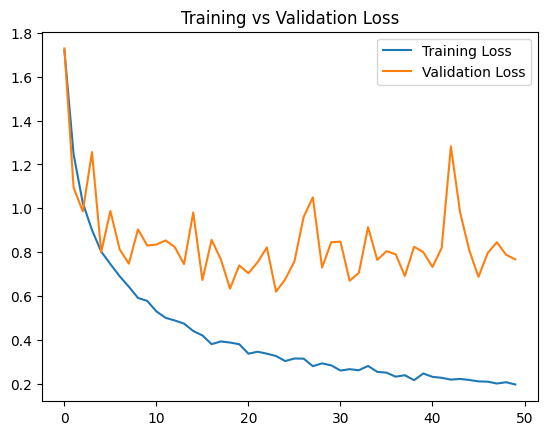

In [23]:
# call plot function to plot the tuned model
plot_result(history)

In [24]:
tuned_cnn_model.save('tuned_cnn_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

  saving_api.save_model(


In [25]:
loaded_tuned_cnn_model = load_model("tuned_cnn_model.h5")

genre_predictions(loaded_tuned_cnn_model, X_test, y_test, 24)

50/50 [==============================] - 1s 10ms/step

Original Genre: classical, Predicted Genre: classical


## RNN

In [45]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras import regularizers

In [46]:
def prepare_data_for_rnn_model(X, y, split_size):
    # divide data in train, val & test
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=split_size)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=split_size)
    
    return X_train, X_val, X_test,  y_train, y_val, y_test

In [47]:
# call process_audio, load_processed_audio_data & prepare_data_for_model functions
if os.path.isfile(output_path) == False:
    process_audio(data_directory, output_path)
X, y = load_processed_audio_data(file_path=output_path)
# spliting data in 80:20 ratio for train & validation and further 80:20 for train & test
X_train, X_val, X_test,  y_train, y_val, y_test = prepare_data_for_rnn_model(X, y, 0.2)

input_shape = X_train.shape[1:]
print(input_shape)

(125, 13)


In [48]:
def rnn_model(input_shape, lstm_unit1=128, lstm_unit2=128, dropout_rate=0.2, kernel_regularizer=0.01, learning_rate=0.001):
    
    model = Sequential([
        LSTM(units=lstm_unit1, input_shape=input_shape, kernel_regularizer=regularizers.l2(kernel_regularizer), return_sequences=True),
        Dropout(dropout_rate),
        LSTM(units=lstm_unit2,  kernel_regularizer=regularizers.l2(kernel_regularizer)),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
                     loss='sparse_categorical_crossentropy',
                     metrics = ['acc']
                     )
    
    return model


In [49]:
print(input_shape)

(125, 13)


In [50]:
rnn_model = rnn_model(input_shape)
rnn_model.summary()

#add early stopping 
early_stopping = EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)
# fit the model
history = rnn_model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=40,
                        batch_size=32,
                        callbacks=[early_stopping]
                        
                    )

Model: "sequential_34"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 lstm_2 (LSTM)               (None, 125, 128)          72704     

                                                                 

 dropout_34 (Dropout)        (None, 125, 128)          0         

                                                                 

 lstm_3 (LSTM)               (None, 128)               131584    

                                                                 

 dense_68 (Dense)            (None, 64)                8256      

                                                                 

 dense_69 (Dense)            (None, 10)                650       

                                                                 


Total params: 213194 (832.79 KB)

Trainable params: 213194 (832.79 KB)

Non-trainable params: 0 (0.00 Byte)

_____________________________________________________________

In [51]:
loss, accuracy = rnn_model.evaluate(X_test, y_test)

print(f'Loss: {loss}, Accuracy: {accuracy}')

50/50 [==============================] - 5s 100ms/step - loss: 0.9364 - acc: 0.7830

Loss: 0.9364135265350342, Accuracy: 0.7829893827438354


### NOTE
- 1st try: LSMT 64 & 2 dense layer around 60%
- 2nd try : LSMT 128 & 2 dense layer avg 70%
- 3rd try: LSMT1 128 & LSMT 64, 2 dense acc = 78.61
- 4th try: LSMT1 128, LSMT2 64, LSMT3 32, 2 densee layer = 79.23
- 5th try: LSMT1 128, LSMT2 64, LSMT3 64, 2 densee layer = 78.36
- 6th try: LSMT1 128, LSMT2 128, LSMT3 64, 2 densee layer = 79.79
- 7th try: LSMT1 128, LSMT2 128, 2 densee layer = 79.92
- 8th try: LSMT1 128, dropout(0.2), LSMT2 128, 2 densee layer = 79.23
- 9th try: LSMT1 128, l2 regularizer(0.01), LSMT2 128,l2 regularizer(0.01), 2 densee layer = 77.73 but stable model with not high overfitting like before cases of RNN & CNN, with 78.73% validation accuracy & 85.59% training accuracy

In [52]:
genre_predictions(rnn_model, X_test, y_test, 24)
genre_predictions(rnn_model, X_test, y_test, 14)
genre_predictions(rnn_model, X_test, y_test, 144)
genre_predictions(rnn_model, X_test, y_test, 121)
genre_predictions(rnn_model, X_test, y_test, 39)
genre_predictions(rnn_model, X_test, y_test, 170)
genre_predictions(rnn_model, X_test, y_test, 25)

50/50 [==============================] - 5s 86ms/step

Original Genre: country, Predicted Genre: country

50/50 [==============================] - 4s 87ms/step

Original Genre: pop, Predicted Genre: pop

50/50 [==============================] - 5s 91ms/step

Original Genre: hiphop, Predicted Genre: hiphop

50/50 [==============================] - 4s 87ms/step

Original Genre: pop, Predicted Genre: pop

50/50 [==============================] - 4s 86ms/step

Original Genre: jazz, Predicted Genre: classical

50/50 [==============================] - 4s 86ms/step

Original Genre: disco, Predicted Genre: disco

50/50 [==============================] - 4s 85ms/step

Original Genre: reggae, Predicted Genre: reggae


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

  with pd.option_context('mode.use_inf_as_na', True):

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

  with pd.option_context('mode.use_inf_as_na', True):

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

  with pd.option_context('mode.use_inf_as_na', True):

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating inste

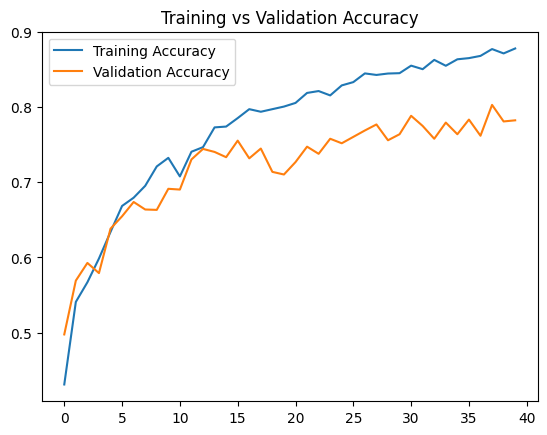

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

  with pd.option_context('mode.use_inf_as_na', True):

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

  with pd.option_context('mode.use_inf_as_na', True):

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

  with pd.option_context('mode.use_inf_as_na', True):

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating inste

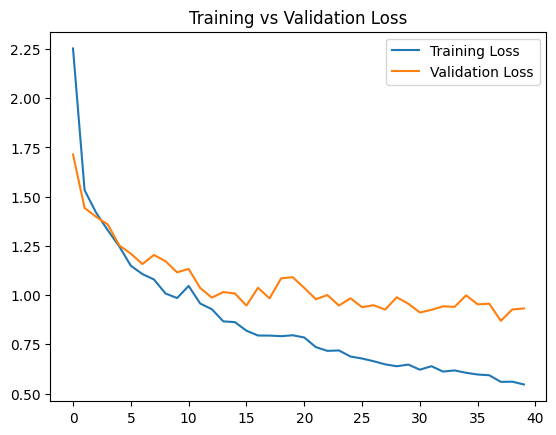

In [53]:
# call plot function to plot the tuned model
plot_result(history)

In [54]:
rnn_model.save('rnn_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

  saving_api.save_model(


In [55]:
loaded_rn_model = load_model("rnn_model.h5")

genre_predictions(loaded_rn_model, X_test, y_test, 24)

50/50 [==============================] - 5s 91ms/step

Original Genre: country, Predicted Genre: country


In [51]:
from sklearn.model_selection import KFold
from keras.callbacks import ReduceLROnPlateau
# define hyper-parameters to tune & perform hyperparameter tuning
param_grid = {
    'lstm_unit1': [32, 64, 128],
    'lstm_unit2': [32, 64, 128],
    'dropout_rate': [0.3, 0.5],
    'kernel_regularizer' : [0.01, 0.05, 0.1],
    'learning_rate' : [0.001, 0.01, 0.1]
}
    
# Using Randomized search CV to find best params
    
model = KerasClassifier(model=rnn_model, epochs=50, batch_size=32, verbose=0,
                        input_shape=input_shape,
                        lstm_unit1=64, lstm_unit2=128, dropout_rate=0.5,
                        kernel_regularizer=0.1,learning_rate=0.1
            )
# print(model.get_params().keys())
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,n_iter=10, 
                                   cv=3, n_jobs=-1, verbose=2, random_state=42)

#add early stopping 
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
#                               verbose=1, mode='min')

result = random_search.fit(X_train, y_train, callbacks=[early_stopping])
    
print("Best: %f using %s" % (random_search.best_score_, random_search.best_params_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


2024-03-08 17:57:04.985861: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered

2024-03-08 17:57:04.986021: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered

2024-03-08 17:57:04.985986: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered

2024-03-08 17:57:04.990297: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered

2024-03-08 17:57:04.991007: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register fac

[CV] END dropout_rate=0.5, kernel_regularizer=0.1, learning_rate=0.1, lstm_unit1=64, lstm_unit2=128; total time=10.6min

[CV] END dropout_rate=0.5, kernel_regularizer=0.05, learning_rate=0.001, lstm_unit1=32, lstm_unit2=64; total time= 4.6min

[CV] END dropout_rate=0.3, kernel_regularizer=0.1, learning_rate=0.001, lstm_unit1=32, lstm_unit2=64; total time= 5.6min

[CV] END dropout_rate=0.3, kernel_regularizer=0.1, learning_rate=0.001, lstm_unit1=32, lstm_unit2=64; total time= 4.6min

[CV] END dropout_rate=0.3, kernel_regularizer=0.05, learning_rate=0.001, lstm_unit1=32, lstm_unit2=128; total time= 8.7min

[CV] END dropout_rate=0.5, kernel_regularizer=0.01, learning_rate=0.1, lstm_unit1=32, lstm_unit2=128; total time= 8.7min


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

  warnings.warn(

2024-03-08 18:40:16.936798: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered

2024-03-08 18:40:16.936885: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered

2024-03-08 18:40:16.938990: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[CV] END dropout_rate=0.5, kernel_regularizer=0.05, learning_rate=0.001, lstm_unit1=32, lstm_unit2=64; total time= 5.6min

[CV] END dropout_rate=0.5, kernel_regularizer=0.05, learning_rate=0.001, lstm_unit1=32, lstm_unit2=64; total time= 5.7min

[CV] END dropout_rate=0.5, kernel_regularizer=0.05, learning_rate=0.1, lstm_unit1=64, lstm_unit2=128; total time= 9.7min

[CV] END dropout_rate=0.5, kernel_regularizer=0.01, learning_rate=0.01, lstm_unit1=64, lstm_unit2=64; total time= 5.6min

[CV] END dropout_rate=0.3, kernel_regularizer=0.05, learning_rate=0.001, lstm_unit1=32, lstm_unit2=128; total time= 9.7min

[CV] END dropout_rate=0.3, kernel_regularizer=0.05, learning_rate=0.1, lstm_unit1=128, lstm_unit2=32; total time= 8.9min


2024-03-08 18:42:36.417002: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered

2024-03-08 18:42:36.417079: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered

2024-03-08 18:42:36.420570: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[CV] END dropout_rate=0.5, kernel_regularizer=0.1, learning_rate=0.1, lstm_unit1=64, lstm_unit2=128; total time=10.7min

[CV] END dropout_rate=0.5, kernel_regularizer=0.05, learning_rate=0.1, lstm_unit1=64, lstm_unit2=128; total time= 9.7min

[CV] END dropout_rate=0.3, kernel_regularizer=0.1, learning_rate=0.001, lstm_unit1=32, lstm_unit2=64; total time= 4.6min

[CV] END dropout_rate=0.5, kernel_regularizer=0.01, learning_rate=0.01, lstm_unit1=64, lstm_unit2=64; total time= 5.7min

[CV] END dropout_rate=0.5, kernel_regularizer=0.01, learning_rate=0.1, lstm_unit1=32, lstm_unit2=128; total time= 8.7min

[CV] END dropout_rate=0.3, kernel_regularizer=0.05, learning_rate=0.1, lstm_unit1=128, lstm_unit2=32; total time= 9.7min


2024-03-08 18:46:26.405767: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered

2024-03-08 18:46:26.407525: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered

2024-03-08 18:46:26.414107: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[CV] END dropout_rate=0.5, kernel_regularizer=0.1, learning_rate=0.1, lstm_unit1=64, lstm_unit2=128; total time=10.7min

[CV] END dropout_rate=0.5, kernel_regularizer=0.05, learning_rate=0.1, lstm_unit1=64, lstm_unit2=128; total time=10.7min

[CV] END dropout_rate=0.5, kernel_regularizer=0.01, learning_rate=0.01, lstm_unit1=64, lstm_unit2=64; total time= 5.2min

[CV] END dropout_rate=0.3, kernel_regularizer=0.05, learning_rate=0.001, lstm_unit1=32, lstm_unit2=128; total time= 9.7min

[CV] END dropout_rate=0.5, kernel_regularizer=0.01, learning_rate=0.1, lstm_unit1=32, lstm_unit2=128; total time= 8.7min

[CV] END dropout_rate=0.5, kernel_regularizer=0.01, learning_rate=0.1, lstm_unit1=32, lstm_unit2=64; total time= 4.3min

[CV] END dropout_rate=0.5, kernel_regularizer=0.1, learning_rate=0.01, lstm_unit1=32, lstm_unit2=32; total time= 4.6min

Best: 0.561865 using {'lstm_unit2': 64, 'lstm_unit1': 32, 'learning_rate': 0.001, 'kernel_regularizer': 0.05, 'dropout_rate': 0.5}


In [52]:
# using best_params generated by randomized search CV to fit model
best_params = random_search.best_params_
tuned_rnn_model = rnn_model(input_shape=input_shape, **best_params)
history = tuned_rnn_model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stopping]
                    )

Epoch 1/50

200/200 [==============================] - 26s 110ms/step - loss: 2.9582 - acc: 0.3595 - val_loss: 1.9327 - val_acc: 0.4149

Epoch 2/50

200/200 [==============================] - 21s 105ms/step - loss: 1.7700 - acc: 0.4453 - val_loss: 1.7520 - val_acc: 0.4344

Epoch 3/50

200/200 [==============================] - 22s 109ms/step - loss: 1.6209 - acc: 0.4804 - val_loss: 1.5791 - val_acc: 0.4950

Epoch 4/50

200/200 [==============================] - 21s 105ms/step - loss: 1.5206 - acc: 0.5104 - val_loss: 1.5743 - val_acc: 0.4990

Epoch 5/50

200/200 [==============================] - 22s 108ms/step - loss: 1.4613 - acc: 0.5293 - val_loss: 1.5517 - val_acc: 0.5155

Epoch 6/50

200/200 [==============================] - 21s 106ms/step - loss: 1.4571 - acc: 0.5287 - val_loss: 1.4863 - val_acc: 0.5175

Epoch 7/50

200/200 [==============================] - 21s 105ms/step - loss: 1.3908 - acc: 0.5429 - val_loss: 1.4627 - val_acc: 0.5450

Epoch 8/50

200/200 [====================

In [ ]:
loss, accuracy = tuned_rnn_model.evaluate(X_test, y_test)

print(f'Loss: {loss}, Accuracy: {accuracy}')

In [ ]:
genre_predictions(rnn_model, X_test, y_test, 24)
genre_predictions(rnn_model, X_test, y_test, 14)
genre_predictions(rnn_model, X_test, y_test, 144)
genre_predictions(rnn_model, X_test, y_test, 121)
genre_predictions(rnn_model, X_test, y_test, 39)
genre_predictions(rnn_model, X_test, y_test, 170)
genre_predictions(rnn_model, X_test, y_test, 25)

In [ ]:
# call plot function to plot the tuned model
plot_result(history)